En este libro se realiza un ejercicio de regresión empleando subclassing Keras.

Para esto se va a usar el conjutno de datos MPG, que contiene información sobre el consumo de gasolina de diferentes tipos de carro y sus respectivas características.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model



print(tf.__version__)

2.8.2


Primero es necesario ubicar la base de datos (disponible online).

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Ahora se importan los datos empleando pandas.

In [3]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


A continuación se van a detectar datos faltantes

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Se identifican 6 datos faltantes. Se van a eliminar para este ejercicio.

In [5]:
dataset = dataset.dropna()

Dado que la columna origin es categórica, se va a convertir en "one-hot".

In [6]:
origin = dataset.pop('Origin')
print(origin)

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64


In [7]:
origin.value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Ahora se dividen los datos en entrenamiento y prueba.

In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.keys()

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

Para el análisis descriptivo se gráfica la relación entre la variable de interés "MPG" y algunas de las regresoras.

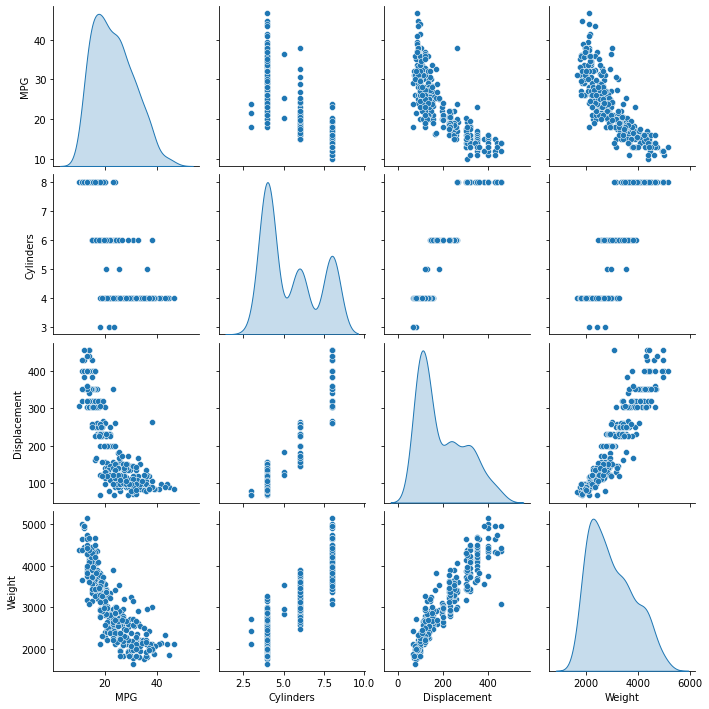

In [10]:
sns.pairplot(train_dataset[["MPG","Cylinders","Displacement","Weight"]],diag_kind="kde")

Ahora se extrae la variable "MPG" para generar las matrices.

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
 train_labels = train_dataset.pop("MPG")
 test_labels = test_dataset.pop("MPG")

Se normalizan los datos.

In [13]:
def norm(x):
  return (x-train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Para la construcción del modelo, se va a usar subclassing, es decir, se fija un objeto que contenga las capas que se quieren usar en cada parte del modelo.

In [14]:
class CNNBlock(layers.Layer):
  def __init__(self, out_channels):
    super(CNNBlock, self).__init__()
    self.dens = layers.Dense(out_channels,activation="relu",input_shape=(normed_train_data.shape[1],))

  def call(self, input_tensor):
    x = self.dens(input_tensor)
    x = tf.nn.relu(x)
    return x

Ahora se define el modelo

In [15]:
model = keras.Sequential([
CNNBlock(64),
CNNBlock(32),
CNNBlock(1)
])

Compilar

In [16]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
              optimizer="Adam",
              metrics=['mae','mse'])

Entrenamiento

In [17]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

epochs = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=epochs, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.555492,1.044124,2.555492,8.177062,2.240586,8.177062,995
996,2.625495,1.055795,2.625495,8.314938,2.282203,8.314938,996
997,2.550330,1.051672,2.550330,8.026044,2.200480,8.026044,997
998,2.614960,1.067843,2.614960,8.160966,2.231375,8.160966,998
999,2.564308,1.046790,2.564308,8.183191,2.244216,8.183191,999


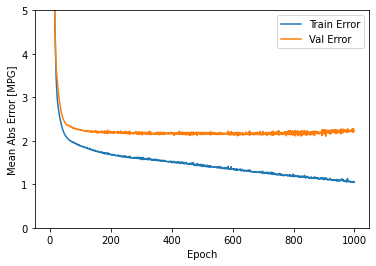

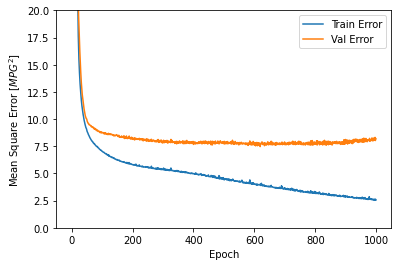

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


....................................................................................................
.

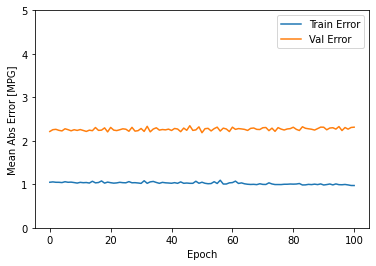

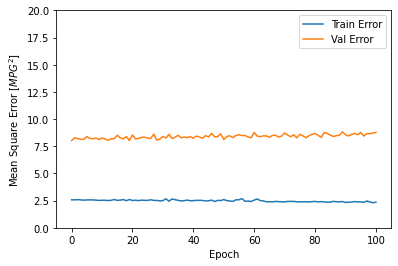

In [20]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.3828 - mae: 1.8524 - mse: 5.3828 - 20ms/epoch - 7ms/step
Testing set Mean Abs Error:  1.85 MPG


Predicciones

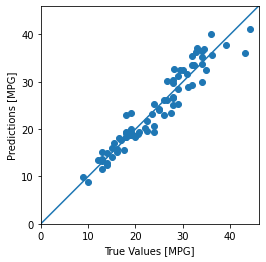

In [22]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_=plt.plot([-100,100],[-100,100])


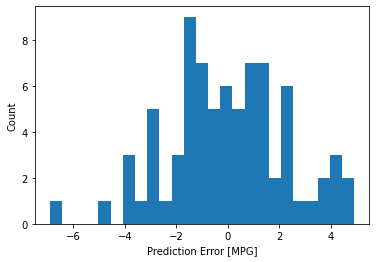

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_=plt.ylabel("Count")